# Transfer Learning with Pretrained VGG-11

## Overview
This project demonstrates the use of transfer learning by leveraging a **VGG-11** convolutional neural network pretrained on the **ImageNet** dataset. Transfer learning enables the model to adapt its learned features to new datasets and tasks, reducing training time and improving performance on smaller datasets.

---

## Features
- **Pretrained Model**:
  - Utilizes the VGG-11 architecture with weights trained on the large-scale ImageNet dataset.
- **Device Configuration**:
  - Automatically detects and uses a GPU if available for faster computation.
- **Transfer Learning Setup**:
  - The model's weights can be fine-tuned or frozen based on the target application.

---

## Key Components
### 1. **Device Configuration**
- Automatically configures the computation device:
  - **GPU**: If available, provides faster training and inference.
  - **CPU**: Fallback for environments without GPU support.

### 2. **Pretrained VGG-11 Model**
- **`torchvision.models.vgg11`**:
  - A 11-layer CNN designed for image classification tasks.
  - Pretrained on the ImageNet dataset with over 1 million images across 1,000 categories.
  - Features a combination of convolutional, ReLU, and max-pooling layers followed by fully connected layers.



In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Imports a VGG-16 model pretrained on ImageNet
vgg11 = torchvision.models.vgg11(pretrained=True, progress=True)
vgg11

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 227MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### Preparing the Dataset for VGG-11 Training

#### **Dataset**
This project uses the **German Traffic Sign Recognition Benchmark (GTSRB)** dataset, which contains images of traffic signs categorized into various classes. The dataset is preprocessed and split into training, validation, and testing sets.

---

#### **Data Transformations**
- **Transforms**:
  - **`ToTensor()`**: Converts images to PyTorch tensors for model compatibility.
  - **`Resize([224, 224])`**: Resizes all images to match the input size expected by the VGG-11 model.
  - **`Normalize([0], [1])`**: Normalizes pixel values to a range suitable for training (standardization).

---

#### **Dataset Splitting**
1. **Training Data**:
   - **`gtsrb_train`**:
     - Contains 75% of the original training dataset after splitting.
   - **Validation Data**:
     - **`gtsrb_val`**:
       - Contains 25% of the original training dataset after splitting.
2. **Testing Data**:
   - **`gtsrb_test`**:
     - Contains the test split of the GTSRB dataset.

---

#### **Workflow**
1. **Data Download**:
   - Downloads the GTSRB dataset if not already present.
   - **Training Split**: Retrieved using `split="train"`.
   - **Testing Split**: Retrieved using `split="test"`.
2. **Preprocessing**:
   - Applies the defined transformations to standardize the dataset and ensure compatibility with VGG-11's input requirements.
3. **Data Splitting**:
   - Randomly splits the training dataset into training and validation subsets:
     - 75% for training.
     - 25% for validation.




In [ ]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224, 224]),
    transforms.Normalize([0], [1])
    ])
# Must resize to VGG11 input size
gtsrb_train = torchvision.datasets.GTSRB('', split="train", transform = transform, download=True)

# We will split out train dataset into train and validation!
gtsrb_train, gtsrb_val = torch.utils.data.random_split(gtsrb_train, [int(np.floor(len(gtsrb_train)*0.75)), int(np.ceil(len(gtsrb_train)*0.25))])

gtsrb_test = torchvision.datasets.GTSRB('', split="test", transform = transform, download=True)

100%|██████████| 187M/187M [00:11<00:00, 15.7MB/s]


Extracting gtsrb/GTSRB-Training_fixed.zip to gtsrb


100%|██████████| 89.0M/89.0M [00:05<00:00, 16.1MB/s]


Extracting gtsrb/GTSRB_Final_Test_Images.zip to gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 182kB/s]


Extracting gtsrb/GTSRB_Final_Test_GT.zip to gtsrb


### Setting Up DataLoaders

#### **Batch Processing**
- **Batch Size**:
  - Set to `100` to process data in manageable chunks, balancing memory usage and training speed.

---

#### **DataLoaders**
- **Purpose**:
  - Efficiently loads data in batches for training, validation, and testing.
  - Handles shuffling for randomness and ensures data is loaded on-demand.
- **Dataloaders Created**:
  - **`train`**:
    - Loads the training subset with a batch size of 100.
    - Data is shuffled automatically for better generalization.
  - **`val`**:
    - Loads the validation subset with a batch size of 100.
    - Shuffling is not required for validation.
  - **`test`**:
    - Loads the test subset with a batch size of 100.
    - Shuffling is enabled to introduce randomness for evaluation.

---

#### **Dataset Sizes**
- **`dataset_sizes`**:
  - A dictionary that stores the number of samples in each split (`train`, `val`, `test`).
  - Provides a quick overview of the dataset distribution for monitoring and debugging.



In [ ]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(gtsrb_train, batch_size=batch_size),
               'val': DataLoader(gtsrb_val, batch_size=batch_size),
               'test': DataLoader(gtsrb_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(gtsrb_train),
                 'val': len(gtsrb_val),
                 'test': len(gtsrb_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 19980, 'val': 6660, 'test': 12630}


### Determining the Number of Classes in the Dataset

#### **Objective**
Identify the total number of unique classes in the **German Traffic Sign Recognition Benchmark (GTSRB)** training dataset. This is essential for configuring the model's output layer to match the classification task.




In [ ]:
# First determine the total number of classes:
gtsrb_labels = set()
for _, labels in dataloaders["train"]:
    for label in labels:
        gtsrb_labels.add(label.item())
print(len(gtsrb_labels))
print(gtsrb_labels)


43
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}


### Visualizing GTSRB Classes and Samples

#### **Functions**
1. **`view_gtsrb_class`**:
   - Displays samples from a specific class in the **GTSRB** dataset.
   - Filters and plots images belonging to the specified class label.

2. **`view_gtsrb_all`**:
   - Iteratively displays examples from all 43 classes in the GTSRB dataset using the `view_gtsrb_class` function.

---

#### **Parameters**
- **`label`** (in `view_gtsrb_class`):
  - The class label of the traffic sign to visualize.
- **`count`** (in `view_gtsrb_class`):
  - The number of images to display for the specified class (default: 1).


In [ ]:
# plot a digit ground truth and autoencoding
def view_gtsrb_class(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # we only want to view a certain class
            if (labels[i] != label):
                continue
            # plot the ground truth
            # ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().permute((1,2,0))
            plt.imshow(input)
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

def view_gtsrb_all():
    for i in range(43):
        view_gtsrb_class(i)

<ipython-input-5-42cc95db15ac>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


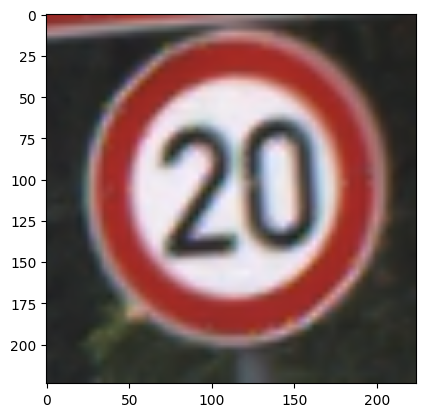

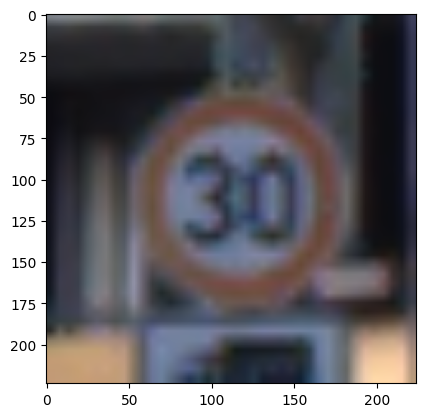

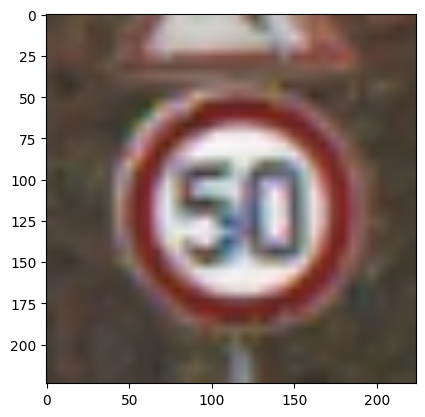

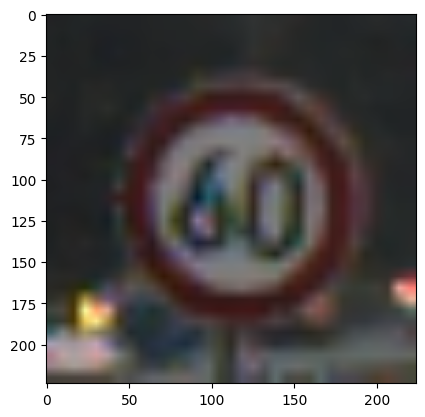

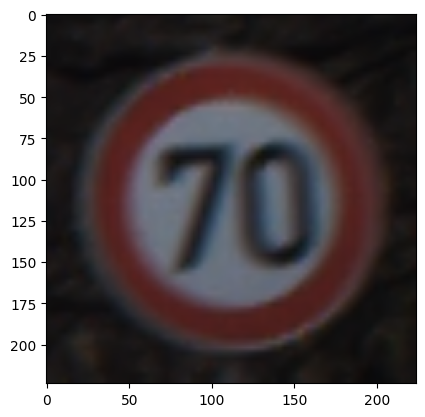

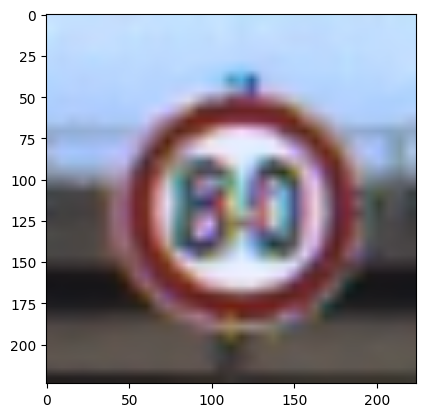

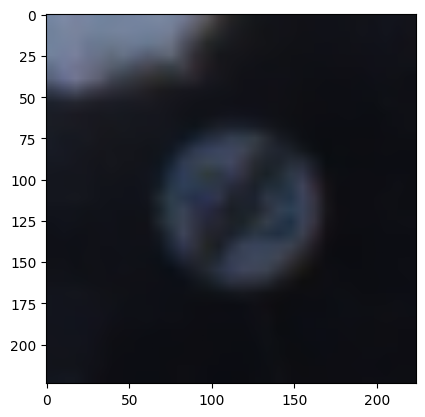

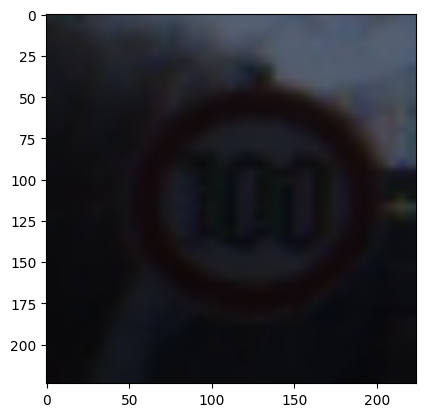

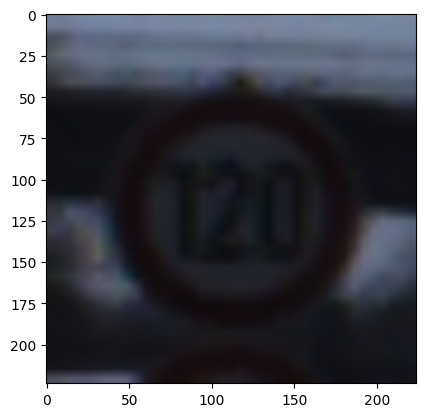

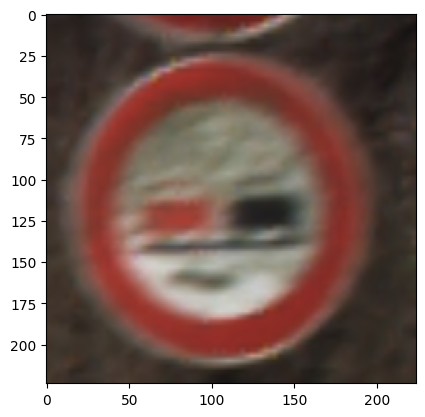

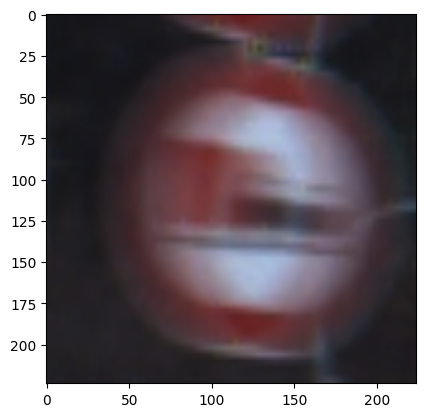

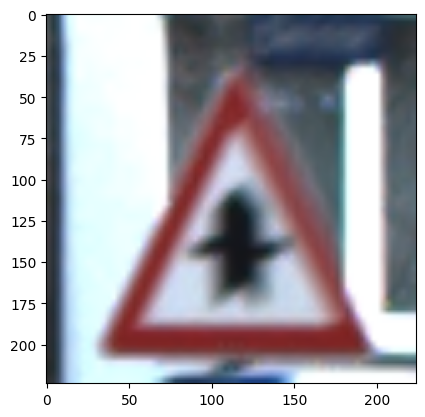

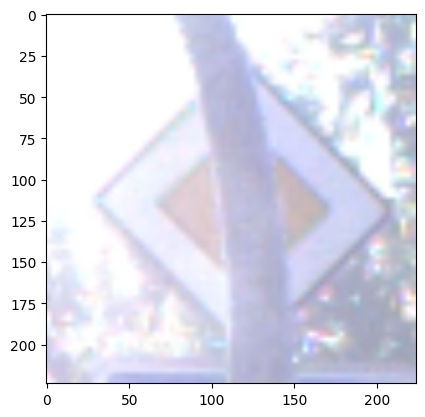

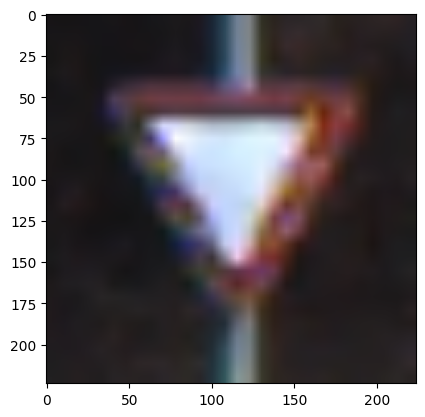

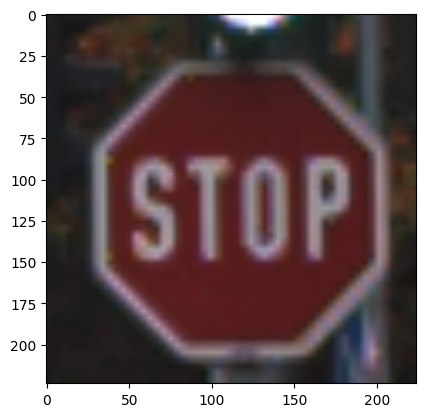

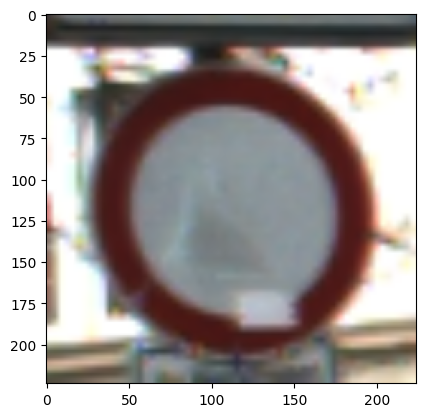

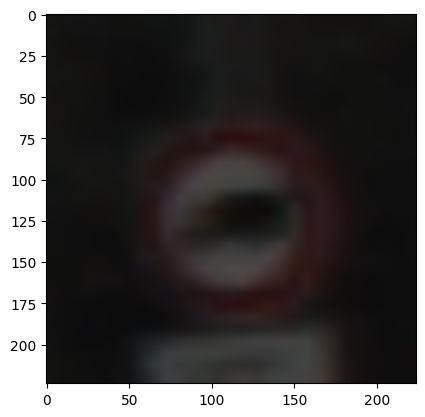

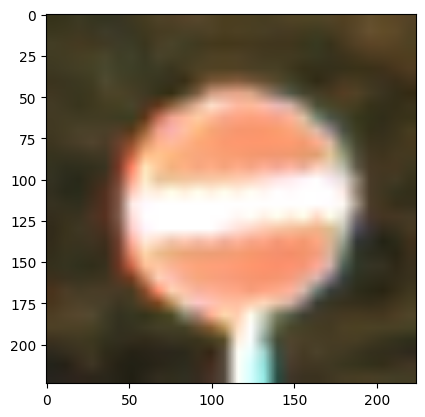

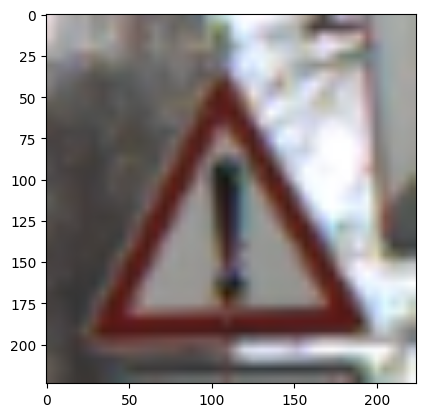

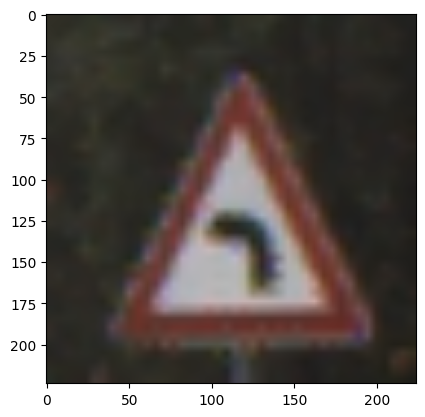

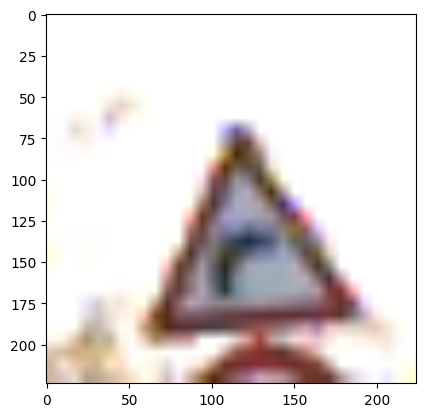

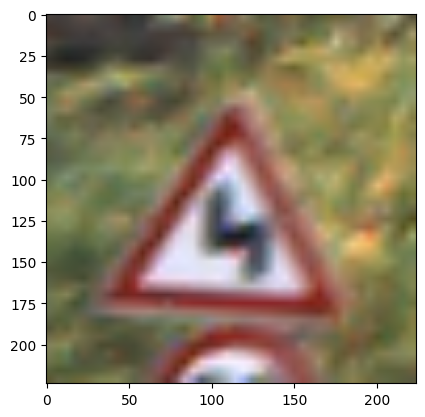

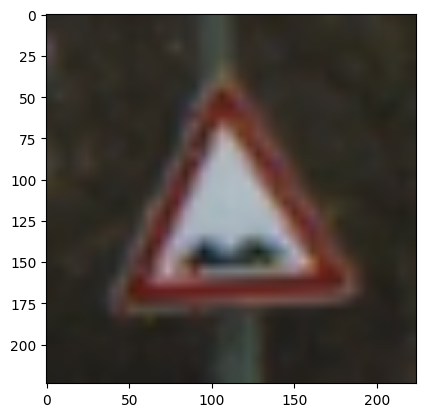

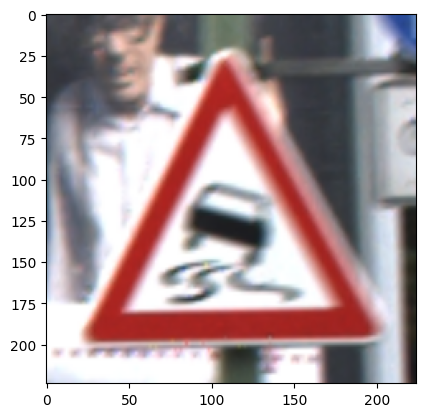

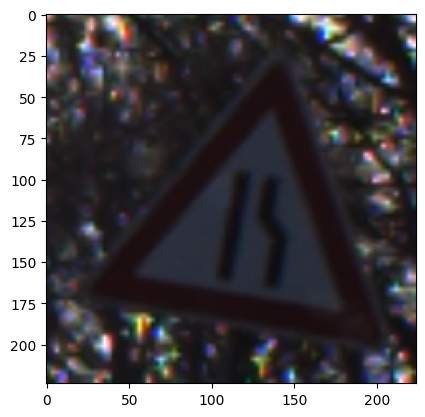

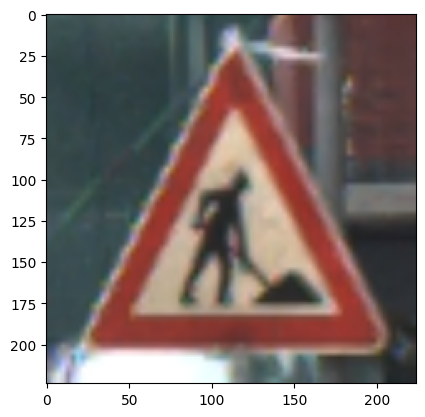

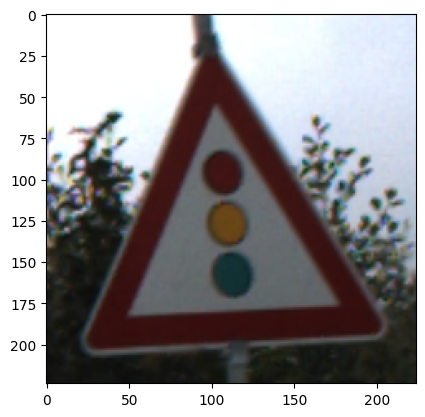

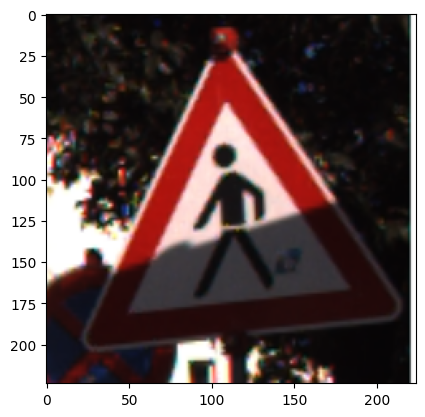

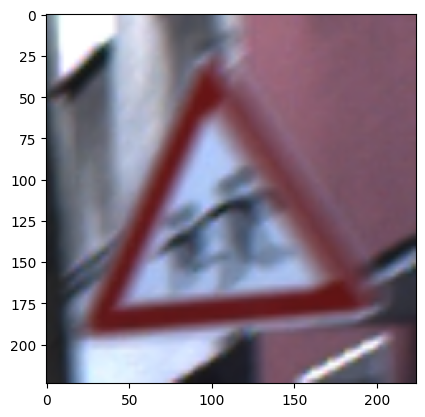

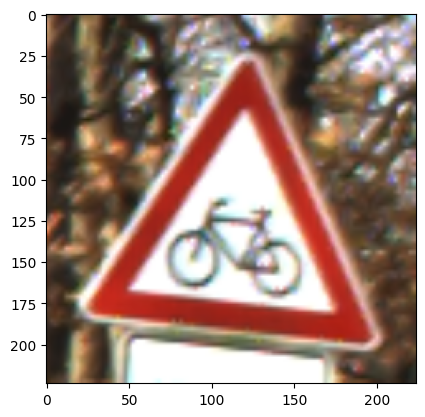

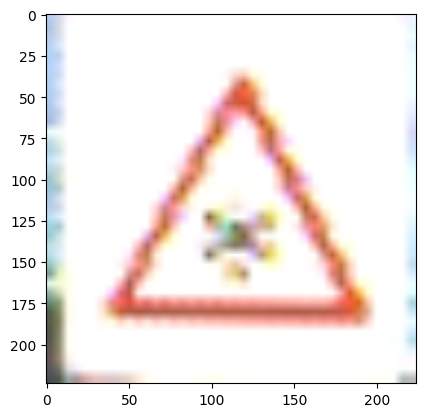

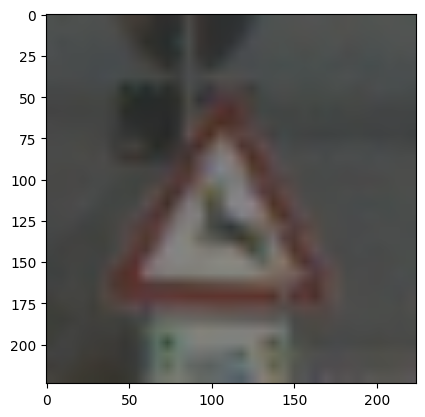

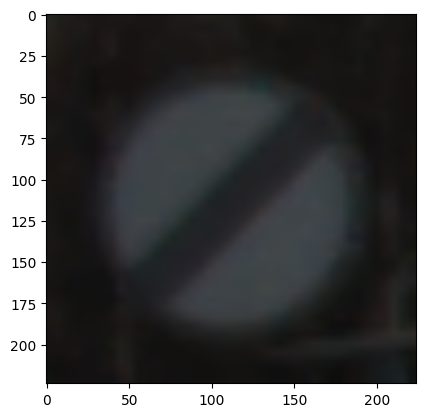

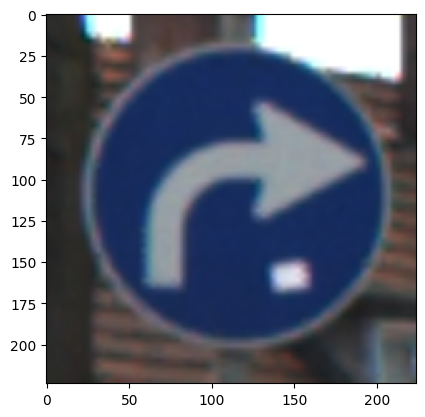

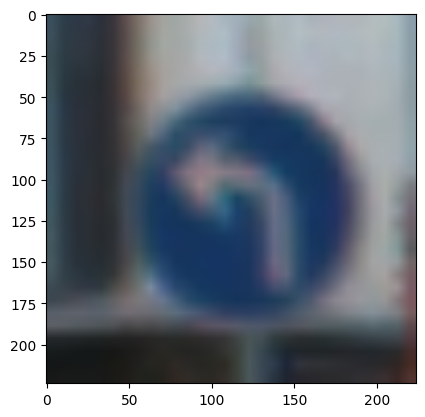

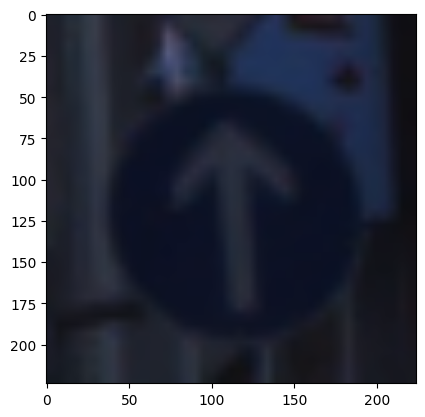

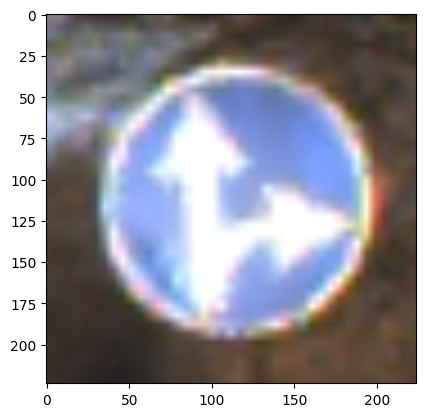

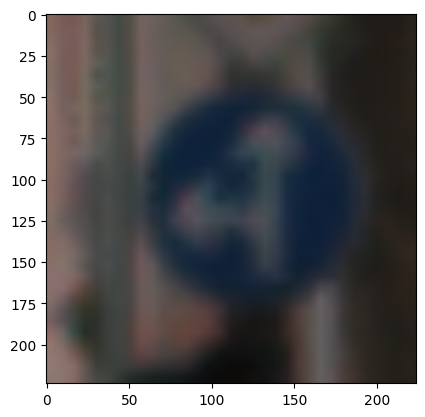

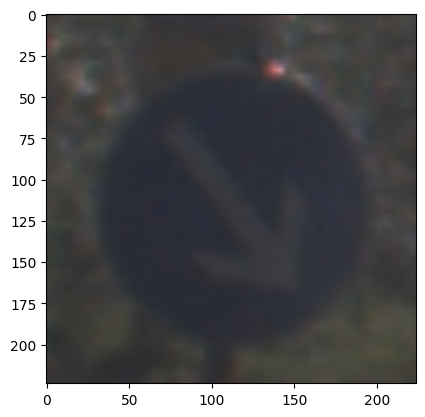

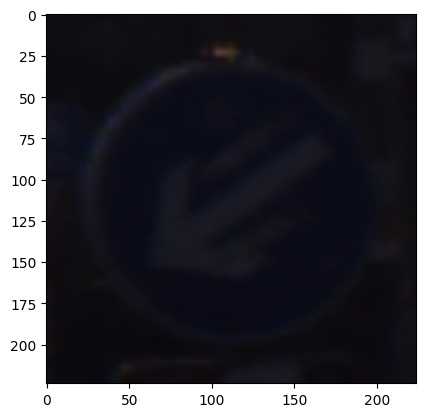

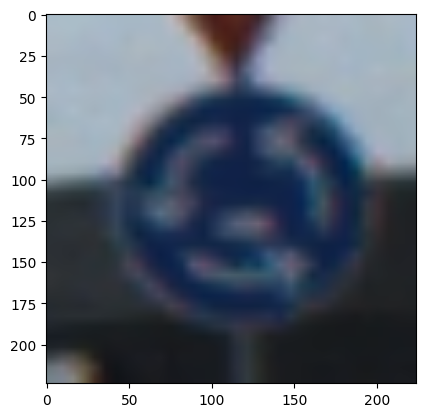

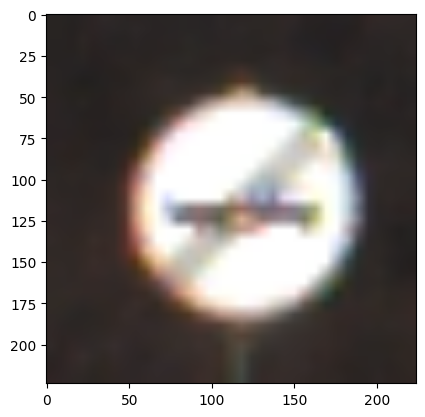

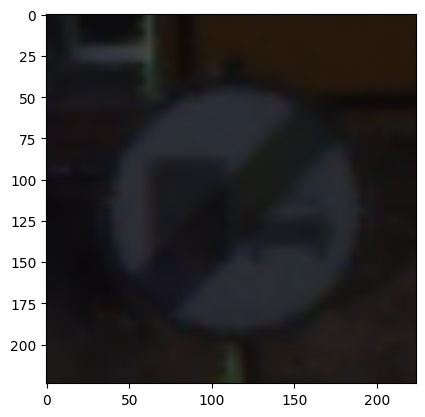

In [ ]:
view_gtsrb_all()

### Adapting VGG-11 for the GTSRB Dataset

#### **1. Freezing Pretrained Weights**
- **`param.requires_grad = False`**:
  - Freezes the weights of all layers in the pretrained VGG-11 model.
  - Prevents these layers from being updated during training, allowing the pretrained features to remain intact.
  - Reduces computational overhead by focusing updates only on the newly added layers.

---

#### **2. Modifying the Output Layer**
- **Replace the Final Fully Connected Layer**:
  - **`vgg11.classifier[6]`**:
    - Replaced with a new linear layer to match the number of classes in the GTSRB dataset.
    - **Input Features**:
      - Matches the output size of the previous layer in the classifier.
    - **Output Features**:
      - Equal to the total number of unique classes in the GTSRB dataset (43).
  - The new layer is trainable by default, enabling fine-tuning for the specific classification task.

---

#### **3. Transfer Model to Device**
- **`vgg11.to(device)`**:
  - Transfers the modified VGG-11 model to the appropriate computation device (GPU or CPU).

---

#### **Purpose**
- **Feature Reuse**:
  - Leverages the powerful feature extraction capabilities of the pretrained VGG-11 layers.
- **Task-Specific Adaptation**:
  - Adjusts the model’s output to align with the classification task for the GTSRB dataset.
- **Efficient Training**:
  - Freezes most of the model’s parameters, reducing the computational cost and training time.


In [ ]:
# Freeze the weights of the network
for param in vgg11.parameters():
    param.requires_grad = False
# Swap the last layer to contain the same number of outputs as classes in our dataset
# New layers have their weights unfrozen by default
vgg11.classifier[6] = nn.Linear(vgg11.classifier[6].in_features, len(gtsrb_labels))
vgg11.to(device)
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### Training the Classification Model

#### **Function: `train_classification_model`**
This function trains a classification model using the provided data loaders, optimizer, loss function, and scheduler. It tracks performance metrics such as loss and accuracy over the training, validation, and test phases.

---

#### **Parameters**
1. **`model`**:
   - The PyTorch model to be trained and evaluated.
2. **`dataloaders`**:
   - Dictionary containing data loaders for the `train`, `val`, and `test` phases.
3. **`dataset_sizes`**:
   - Dictionary with the number of samples in each dataset phase.
4. **`criterion`**:
   - Loss function used to compute the model’s error (e.g., CrossEntropyLoss).
5. **`optimizer`**:
   - Optimizer used to update model weights (e.g., Adam or SGD).
6. **`scheduler`**:
   - Learning rate scheduler for dynamically adjusting the learning rate.
7. **`num_epochs`** (default: 25):
   - Number of epochs for training the model.

---

#### **Workflow**
1. **Initialization**:
   - Saves the best model weights and initializes tracking for loss and accuracy metrics.
2. **Epoch Loop**:
   - Iterates through a specified number of epochs, alternating between training, validation, and test phases.
3. **Phase Handling**:
   - **Training Phase**:
     - Sets the model to training mode and updates weights using backpropagation.
   - **Validation and Test Phases**:
     - Sets the model to evaluation mode and evaluates performance without updating weights.
4. **Metrics Calculation**:
   - **Loss**: Average loss over the dataset for the current phase.
   - **Accuracy**: Percentage of correctly classified samples.
5. **Best Model Tracking**:
   - Tracks the best validation accuracy and saves the corresponding model weights.

---

#### **Outputs**
1. **Trained Model**:
   - Returns the model with the best weights (based on validation accuracy).
2. **Training Curves**:
   - Dictionary containing loss and accuracy metrics for each phase over all epochs.

---

#### **Key Features**
- **Dynamic Learning Rate**:
  - Adjusts the learning rate during training using the provided scheduler.
- **Early Stopping**:
  - Automatically tracks the best validation accuracy and stops training if needed.
- **Comprehensive Evaluation**:
  - Evaluates the model on separate training, validation, and test datasets.


In [ ]:
def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves


### Training Configuration and Execution for VGG-11

#### **1. Hyperparameters**
- **`learning_rate = 0.001`**:
  - Sets the step size for updating model weights during training.
- **`num_epochs = 10`**:
  - Specifies the number of complete passes through the dataset.

---

#### **2. Loss Function**
- **`criterion = nn.CrossEntropyLoss()`**:
  - Computes the classification loss by comparing the predicted probabilities with the true class labels.
  - Suitable for multi-class classification tasks like traffic sign recognition.

---

#### **3. Optimizer**
- **`optimizer = torch.optim.Adam(vgg11.parameters(), lr=learning_rate)`**:
  - Optimizes the model weights using the Adam algorithm, which combines the benefits of momentum and adaptive learning rates.
  - Learning rate: `0.001`.

---

#### **4. Learning Rate Scheduler**
- **`scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)`**:
  - Gradually reduces the learning rate by a factor of `0.95` after each epoch to stabilize training as the model converges.

---

#### **5. Training the Model**
- **`train_classification_model`**:
  - Trains the modified VGG-11 model on the GTSRB dataset for `10` epochs.
  - Tracks training, validation, and test performance using the specified `dataloaders` and `dataset_sizes`.



In [ ]:
learning_rate = 0.001
num_epochs = 10

# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(vgg11.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
vgg11_phase1, training_curves_phase1 = train_classification_model(vgg11, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 1.7877 Acc: 0.4851
val   Loss: 1.2502 Acc: 0.6593
test  Loss: 1.6099 Acc: 0.5268

Epoch 2/10
----------
train Loss: 1.2277 Acc: 0.6292
val   Loss: 1.0041 Acc: 0.7296
test  Loss: 1.4526 Acc: 0.5679

Epoch 3/10
----------
train Loss: 1.0797 Acc: 0.6678
val   Loss: 0.8813 Acc: 0.7659
test  Loss: 1.3750 Acc: 0.5927

Epoch 4/10
----------
train Loss: 1.0114 Acc: 0.6856
val   Loss: 0.7999 Acc: 0.7892
test  Loss: 1.3341 Acc: 0.6059

Epoch 5/10
----------
train Loss: 0.9504 Acc: 0.7046
val   Loss: 0.7527 Acc: 0.8024
test  Loss: 1.3111 Acc: 0.6105

Epoch 6/10
----------
train Loss: 0.9104 Acc: 0.7108
val   Loss: 0.7144 Acc: 0.8099
test  Loss: 1.2985 Acc: 0.6090

Epoch 7/10
----------
train Loss: 0.8820 Acc: 0.7247
val   Loss: 0.6723 Acc: 0.8294
test  Loss: 1.2708 Acc: 0.6226

Epoch 8/10
----------
train Loss: 0.8672 Acc: 0.7283
val   Loss: 0.6524 Acc: 0.8324
test  Loss: 1.2528 Acc: 0.6300

Epoch 9/10
----------
train Loss: 0.8446 Acc: 0.7287
val   Loss: 0.6327

### Visualization and Evaluation Functions for Classification

#### **1. Plot Training Curves**
**`plot_training_curves(training_curves, phases=['train', 'val', 'test'], metrics=['loss', 'acc'])`**
- **Purpose**:
  - Visualizes the training progress by plotting loss and accuracy metrics for each phase (train, validation, and test) over all epochs.
- **Key Features**:
  - Plots separate curves for each metric (`loss`, `accuracy`) and phase.
  - Dynamically adjusts based on the data in `training_curves`.
- **Workflow**:
  1. Iterates over specified metrics and phases.
  2. Plots epoch-wise trends for each metric and phase.
  - **X-axis**: Epochs.
  - **Y-axis**: Metric values (loss or accuracy).
- **Output**:
  - A line plot for each metric showing trends across training, validation, and test phases.

---

#### **2. Classify Predictions**
**`classify_predictions(model, device, dataloader)`**
- **Purpose**:
  - Generates predictions for the dataset and collects ground-truth labels, prediction scores, and class predictions.
- **Workflow**:
  1. Sets the model to evaluation mode to disable weight updates.
  2. Iterates through the data loader:
     - Passes inputs through the model.
     - Computes softmax probabilities for predictions.
     - Extracts predicted classes and scores.
     - Collects ground-truth labels, predictions, and scores in tensors.
- **Output**:
  - **`all_preds`**: Predicted classes for each sample.
  - **`all_labels`**: True labels for each sample.
  - **`all_scores`**: Prediction confidence scores.

---

#### **3. Plot Confusion Matrix**
**`plot_cm(model, device, dataloaders, phase='test')`**
- **Purpose**:
  - Visualizes the classification performance using a confusion matrix.
- **Workflow**:
  1. Uses the `classify_predictions` function to get predictions and ground-truth labels for the specified phase.
  2. Computes the confusion matrix using `sklearn.metrics.confusion_matrix`.
  3. Displays the matrix with labels using `ConfusionMatrixDisplay`.
  - **Rows**: True labels.
  - **Columns**: Predicted labels.
- **Output**:
  - A confusion matrix plot showing the counts of true positives, false positives, and false negatives for each class.



In [ ]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([])
    all_scores = torch.tensor([])
    all_preds = torch.tensor([])
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels.detach().cpu()), 0)
        all_scores = torch.cat((all_scores, scores.detach().cpu()), 0)
        all_preds = torch.cat((all_preds, preds.detach().cpu()), 0)
    return all_preds, all_labels, all_scores

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')

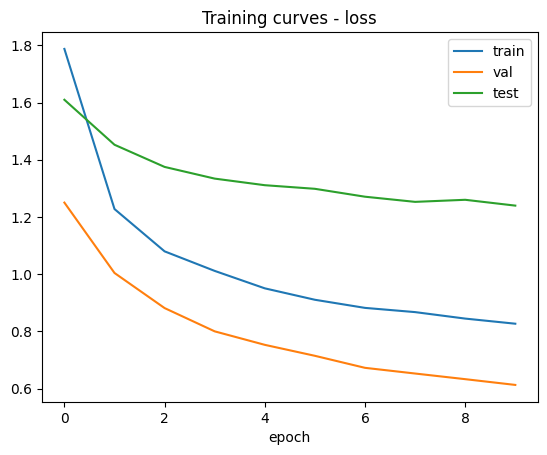

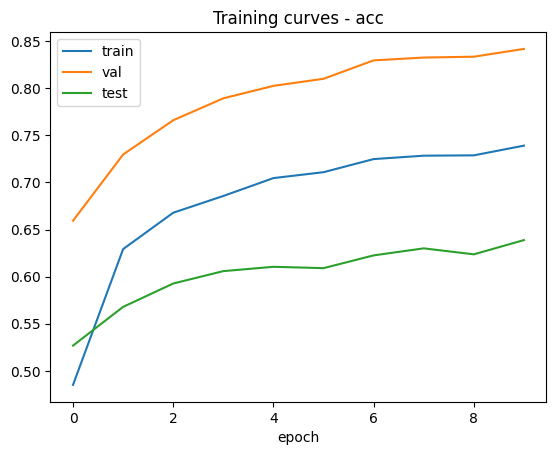

In [ ]:
plot_training_curves(training_curves_phase1, phases=['train', 'val', 'test'])

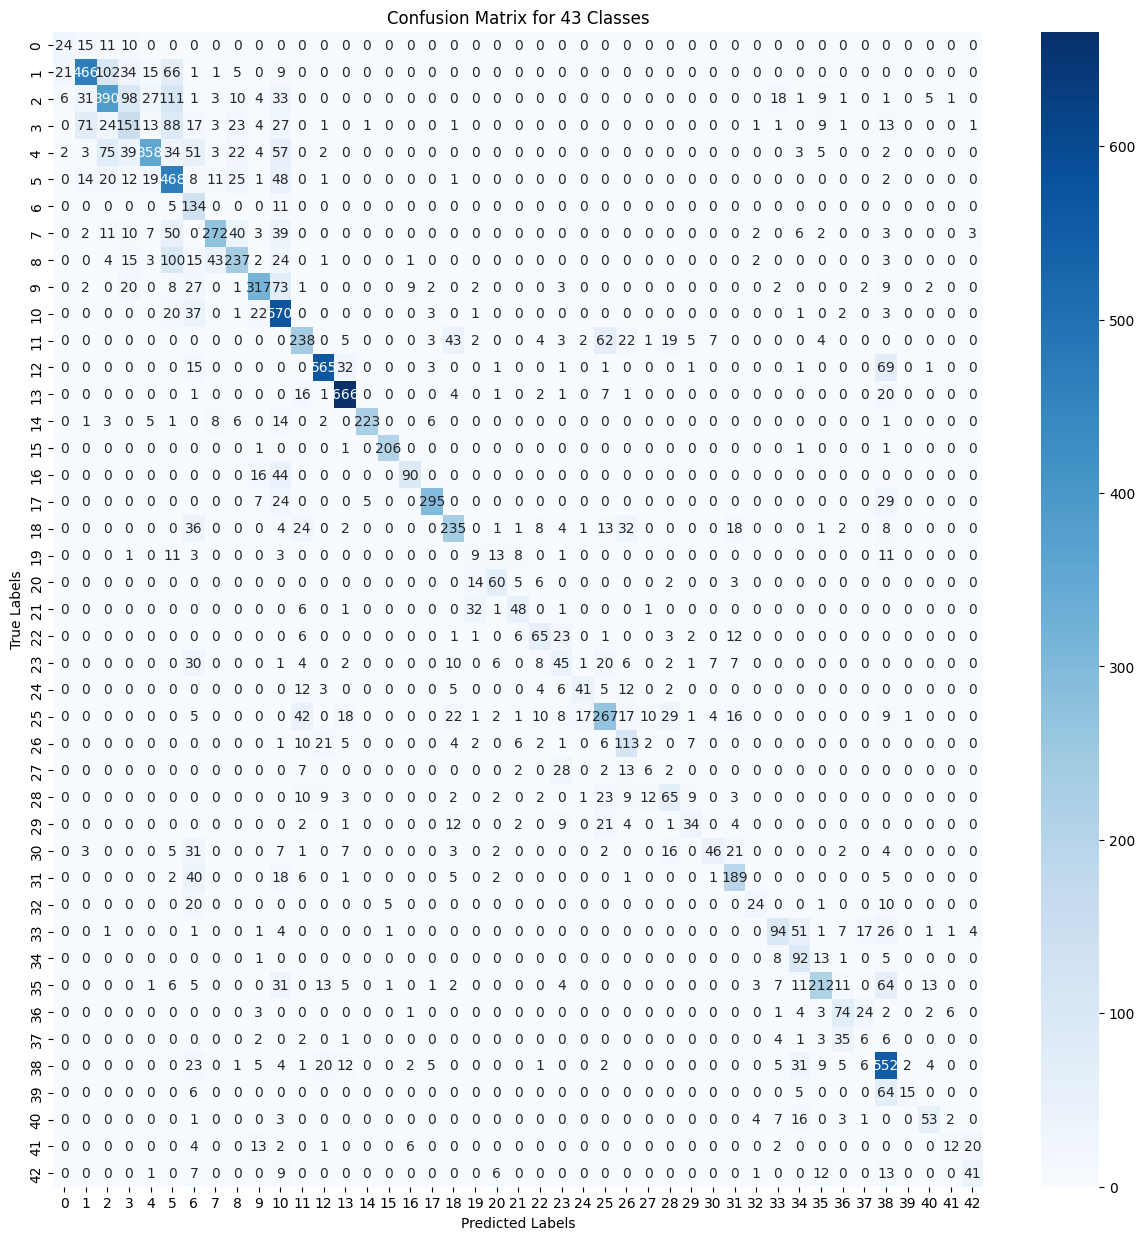

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# res = plot_cm(vgg11_phase1, device, dataloaders, phase='test')
def plot_cm(model, device, dataloaders, phase='test'):
    # Lists to hold true labels and predictions
    true_labels = []
    preds = []

    # Set the model to evaluation mode and gather predictions
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            preds.extend(predictions.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, preds)

    # Create a list of labels from 0 to 42 (for the 43 classes)
    class_labels = [str(i) for i in range(43)]

    # Plot the confusion matrix with Seaborn's heatmap
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)

    # Add labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for 43 Classes')
    plt.show()

# Example usage
res = plot_cm(vgg11_phase1, device, dataloaders, phase='test')

### Phase Two: Fine-Tuning the Model

#### **Unfreezing Weights**
**`for param in vgg11_phase1.parameters(): param.requires_grad = True`**
- **Purpose**:
  - In phase two, the weights of the pretrained VGG-11 model, which were frozen in phase one, are now unfrozen.
  - This allows the model to update all weights during training, enabling fine-tuning of the entire network.
- **Key Features**:
  - Previously frozen layers (convolutional layers in the feature extractor) can now adapt to the specific characteristics of the GTSRB dataset.
  - Retains knowledge from the pretrained ImageNet features while fine-tuning for better task-specific performance.


In [ ]:
# Un-Freeze the weights of the network
for param in vgg11_phase1.parameters():
    param.requires_grad = True

### Fine-Tuning the Model: Phase Two

#### **1. Loss Function**
- **`criterion = nn.CrossEntropyLoss()`**:
  - Computes the classification error between the model’s predictions and the true labels.
  - Suitable for multi-class classification tasks like traffic sign recognition.

---

#### **2. Optimizer**
- **`optimizer = torch.optim.Adam(vgg11_phase1.parameters(), lr=learning_rate)`**:
  - Updates all model weights, including those unfrozen in phase two, using the Adam optimization algorithm.
  - Learning rate: `0.001` (previously defined).

---

#### **3. Learning Rate Scheduler**
- **`scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)`**:
  - Reduces the learning rate by a factor of `0.95` after each epoch.
  - Helps stabilize training and encourages convergence as the model fine-tunes.

---

#### **4. Training the Model**
- **`train_classification_model`**:
  - Continues training the model for additional epochs in phase two.
  - Fine-tunes the entire network, leveraging both the previously frozen pretrained features and the newly updated layers.
- **Parameters**:
  - **`vgg11_phase1`**: The model with unfrozen weights.
  - **`dataloaders`**: Contains training, validation, and test data loaders.
  - **`dataset_sizes`**: Number of samples in each dataset phase.
  - **`num_epochs`**: Number of epochs for phase two training.


In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(vgg11_phase1.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
vgg11_phase2, training_curves_phase2 = train_classification_model(vgg11_phase1, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 3.4379 Acc: 0.1495
val   Loss: 1.8076 Acc: 0.4083
test  Loss: 1.8660 Acc: 0.4097

Epoch 2/10
----------
train Loss: 1.3694 Acc: 0.5513
val   Loss: 0.7462 Acc: 0.7462
test  Loss: 0.9927 Acc: 0.6786

Epoch 3/10
----------
train Loss: 0.5000 Acc: 0.8383
val   Loss: 0.2485 Acc: 0.9219
test  Loss: 0.5075 Acc: 0.8511

Epoch 4/10
----------
train Loss: 0.2342 Acc: 0.9275
val   Loss: 0.1269 Acc: 0.9638
test  Loss: 0.3709 Acc: 0.9034

Epoch 5/10
----------
train Loss: 0.1341 Acc: 0.9589
val   Loss: 0.1076 Acc: 0.9682
test  Loss: 0.4233 Acc: 0.9005

Epoch 6/10
----------
train Loss: 0.1040 Acc: 0.9674
val   Loss: 0.1042 Acc: 0.9700
test  Loss: 0.4016 Acc: 0.9011

Epoch 7/10
----------
train Loss: 0.0754 Acc: 0.9772
val   Loss: 0.0835 Acc: 0.9755
test  Loss: 0.3453 Acc: 0.9077

Epoch 8/10
----------
train Loss: 0.0563 Acc: 0.9828
val   Loss: 0.0660 Acc: 0.9817
test  Loss: 0.3020 Acc: 0.9245

Epoch 9/10
----------
train Loss: 0.0546 Acc: 0.9831
val   Loss: 0.0593

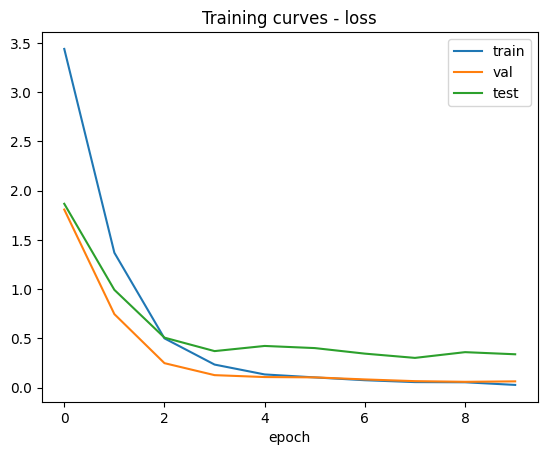

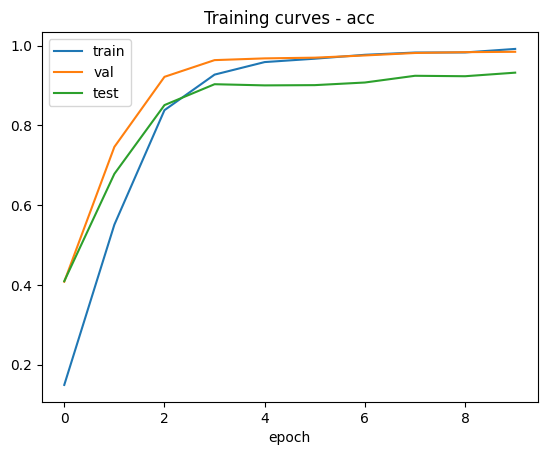

In [ ]:
plot_training_curves(training_curves_phase2, phases=['train', 'val', 'test'])

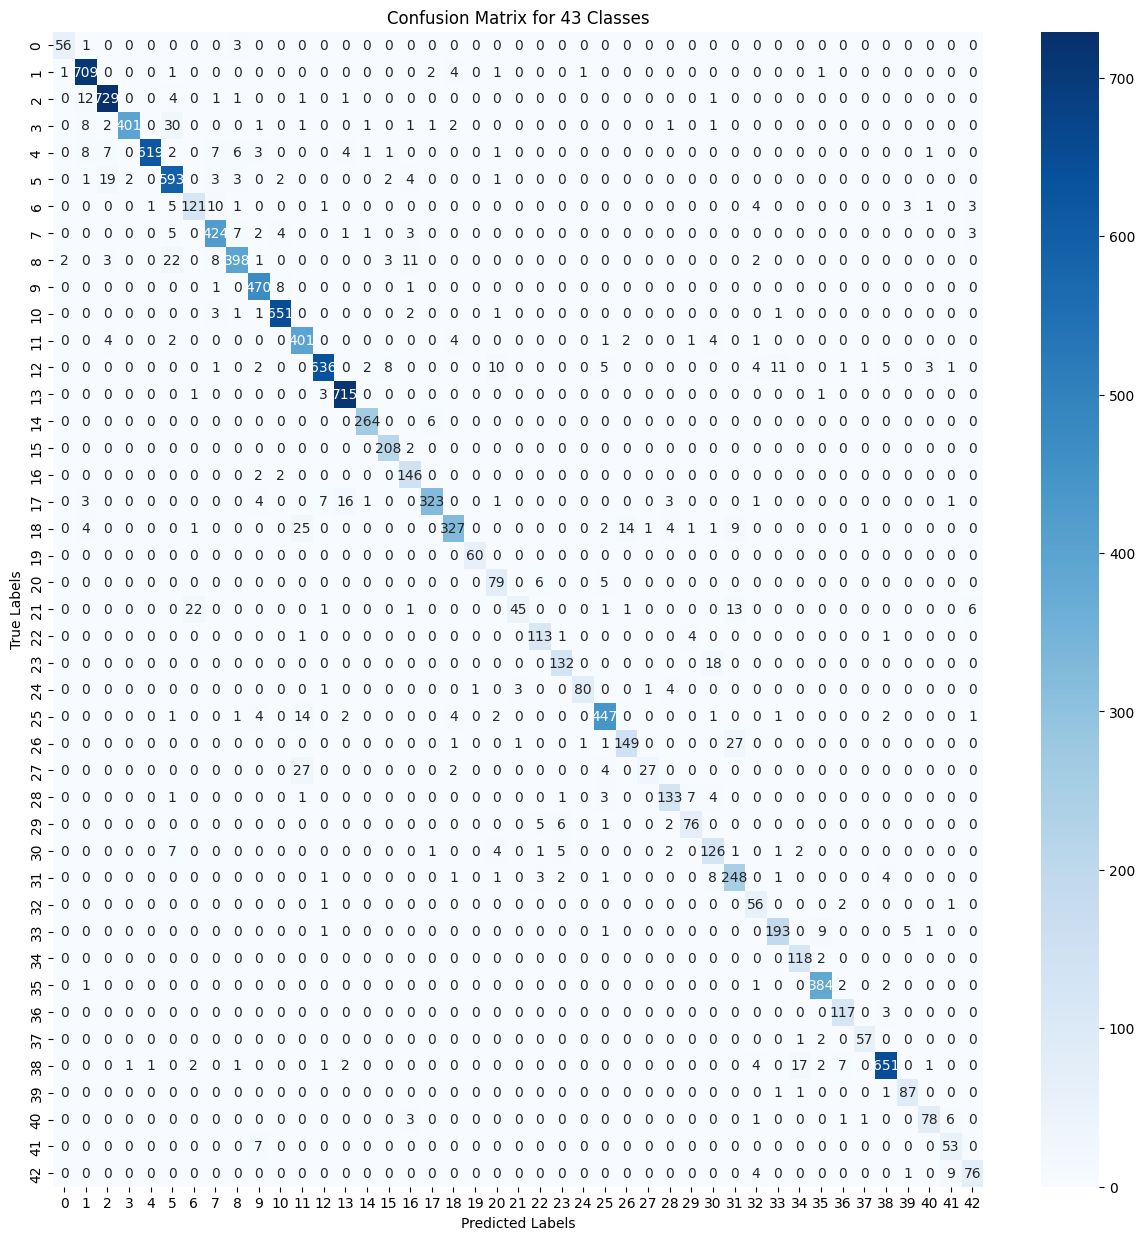

In [ ]:
def plot_cm(model, device, dataloaders, phase='test'):
    # Lists to hold true labels and predictions
    true_labels = []
    preds = []

    # Set the model to evaluation mode and gather predictions
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            preds.extend(predictions.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, preds)

    # Create a list of labels from 0 to 42 (for the 43 classes)
    class_labels = [str(i) for i in range(43)]

    # Plot the confusion matrix with Seaborn's heatmap
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)

    # Add labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for 43 Classes')
    plt.show()

# Example usage
res = plot_cm(vgg11_phase1, device, dataloaders, phase='test')